In [166]:
import json
import datetime

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
import xgboost as xgb

import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

# Loading data

## Load file

In [179]:
df = pd.read_csv(
  'X_train_Hi5.csv',
  #nrows=1000000,
  dtype={
    'piezo_station_commune_code_insee': str,
    'piezo_station_department_code': str,
    'piezo_qualification': 'category'
  },
  usecols=[
    # PIEZOMETRY COLUMNS
    'piezo_measurement_date', 'piezo_station_department_code', 'piezo_station_bss_id', 'piezo_groundwater_level_category', 'piezo_station_longitude', 'piezo_station_latitude', 'piezo_qualification',
    
    # WEATHER COLUMNS
    'meteo_temperature_avg', 'meteo_humidity_avg', 'meteo_evapotranspiration_grid', 'meteo_frost_duration', 'meteo_rain_height',
    
    # HYDRO COLUMNS
    'hydro_longitude', 'hydro_latitude', 'hydro_observation_result_elab',
    
    # INSEE COLUMNS
    'insee_pop_commune', 'insee_%_agri', "insee_%_const", "insee_med_living_level", "insee_%_ind",
    
    # WITHDRAWALS
    'prelev_latitude_0', 'prelev_longitude_0', 'prelev_usage_label_0', 'prelev_volume_0',
  ]
)

/tmp/ipykernel_27601/194469389.py:1: DtypeWarning:

Columns (110) have mixed types. Specify dtype option on import or set low_memory=False.



## Parse fields

In [180]:
# Label encoding for better visualization and averages
df['piezo_groundwater_level_value'] = df['piezo_groundwater_level_category'].map({
  'Very Low': 1,
  'Low': 2,
  'Average': 3,
  'High': 4,
  'Very High': 5,
})

In [181]:
df['piezo_qualification'] = pd.factorize(df['piezo_qualification'])[0]
df['piezo_measurement_date'] = pd.to_datetime(df['piezo_measurement_date'])

## General description

In [3]:
df.describe()

,row_index,piezo_station_investigation_depth,piezo_station_altitude,piezo_station_longitude,piezo_station_latitude,piezo_continuity_code,piezo_producer_code,meteo_id,meteo_latitude,meteo_longitude,...,prelev_longitude_1,prelev_latitude_1,prelev_commune_code_insee_1,prelev_volume_2,prelev_longitude_2,prelev_latitude_2,prelev_commune_code_insee_2,prelev_other_volume_sum,insee_pop_commune,piezo_groundwater_level_value
count,1.000000e+06,937548.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,9.424620e+05,1.000000e+06,1000000.000000,1000000.000000,...,989454.000000,989454.000000,989454.000000,9.890540e+05,989054.000000,989054.000000,989054.000000,1.000000e+06,990425.000000,1000000.000000
mean,5.259083e+05,85.989418,146.696957,2.219283,46.423127,1.999155,5.576371e+12,3.743447e+07,2.194065,46.428918,...,2.134383,46.469199,44939.733528,3.472250e+08,2.139828,46.463854,45133.739468,2.691062e+08,7068.128614,2.997413
std,3.036223e+05,245.772675,192.041580,2.723874,2.173712,0.029057,1.127007e+13,2.078456e+07,2.683729,2.138015,...,2.645670,2.145600,24650.460897,2.420963e+09,2.644736,2.144151,24761.528427,1.521827e+09,32699.539706,1.367189
min,0.000000e+00,0.000000,-999.000000,-4.657129,41.399732,1.000000,1.960000e+02,1.027003e+06,-4.664167,42.384667,...,-4.487265,42.407792,1010.000000,1.541000e+03,-4.731051,42.407792,1027.000000,0.000000e+00,6.000000,1.000000
25%,2.629688e+05,16.500000,41.000000,-0.105584,44.497506,2.000000,2.910000e+02,1.913900e+07,-0.152000,44.534667,...,-0.200520,44.559155,26035.000000,6.877600e+05,-0.150385,44.572622,26009.000000,1.080165e+07,479.000000,2.000000
50%,5.260015e+05,38.000000,107.070000,1.897576,46.401557,2.000000,3.000000e+02,3.420900e+07,1.903167,46.417000,...,1.821023,46.513381,40332.000000,1.547946e+06,1.824518,46.489852,40313.000000,2.097502e+07,1234.000000,3.000000
75%,7.888242e+05,80.000000,185.000000,4.203498,48.216560,2.000000,1.219000e+03,5.244800e+07,4.198667,48.205167,...,4.076880,48.250773,66209.000000,8.796923e+06,4.071172,48.250773,67462.000000,5.217829e+07,3728.000000,4.000000
max,1.051860e+06,5233.400000,2150.000000,9.519890,50.971087,2.000000,4.930211e+13,9.558000e+07,8.145500,50.833833,...,8.087510,50.948383,95170.000000,3.596148e+10,8.097045,50.864884,94054.000000,2.566101e+10,873076.000000,5.000000


In [ ]:
df.isna().sum()

## Correlation matrix

<Axes: >

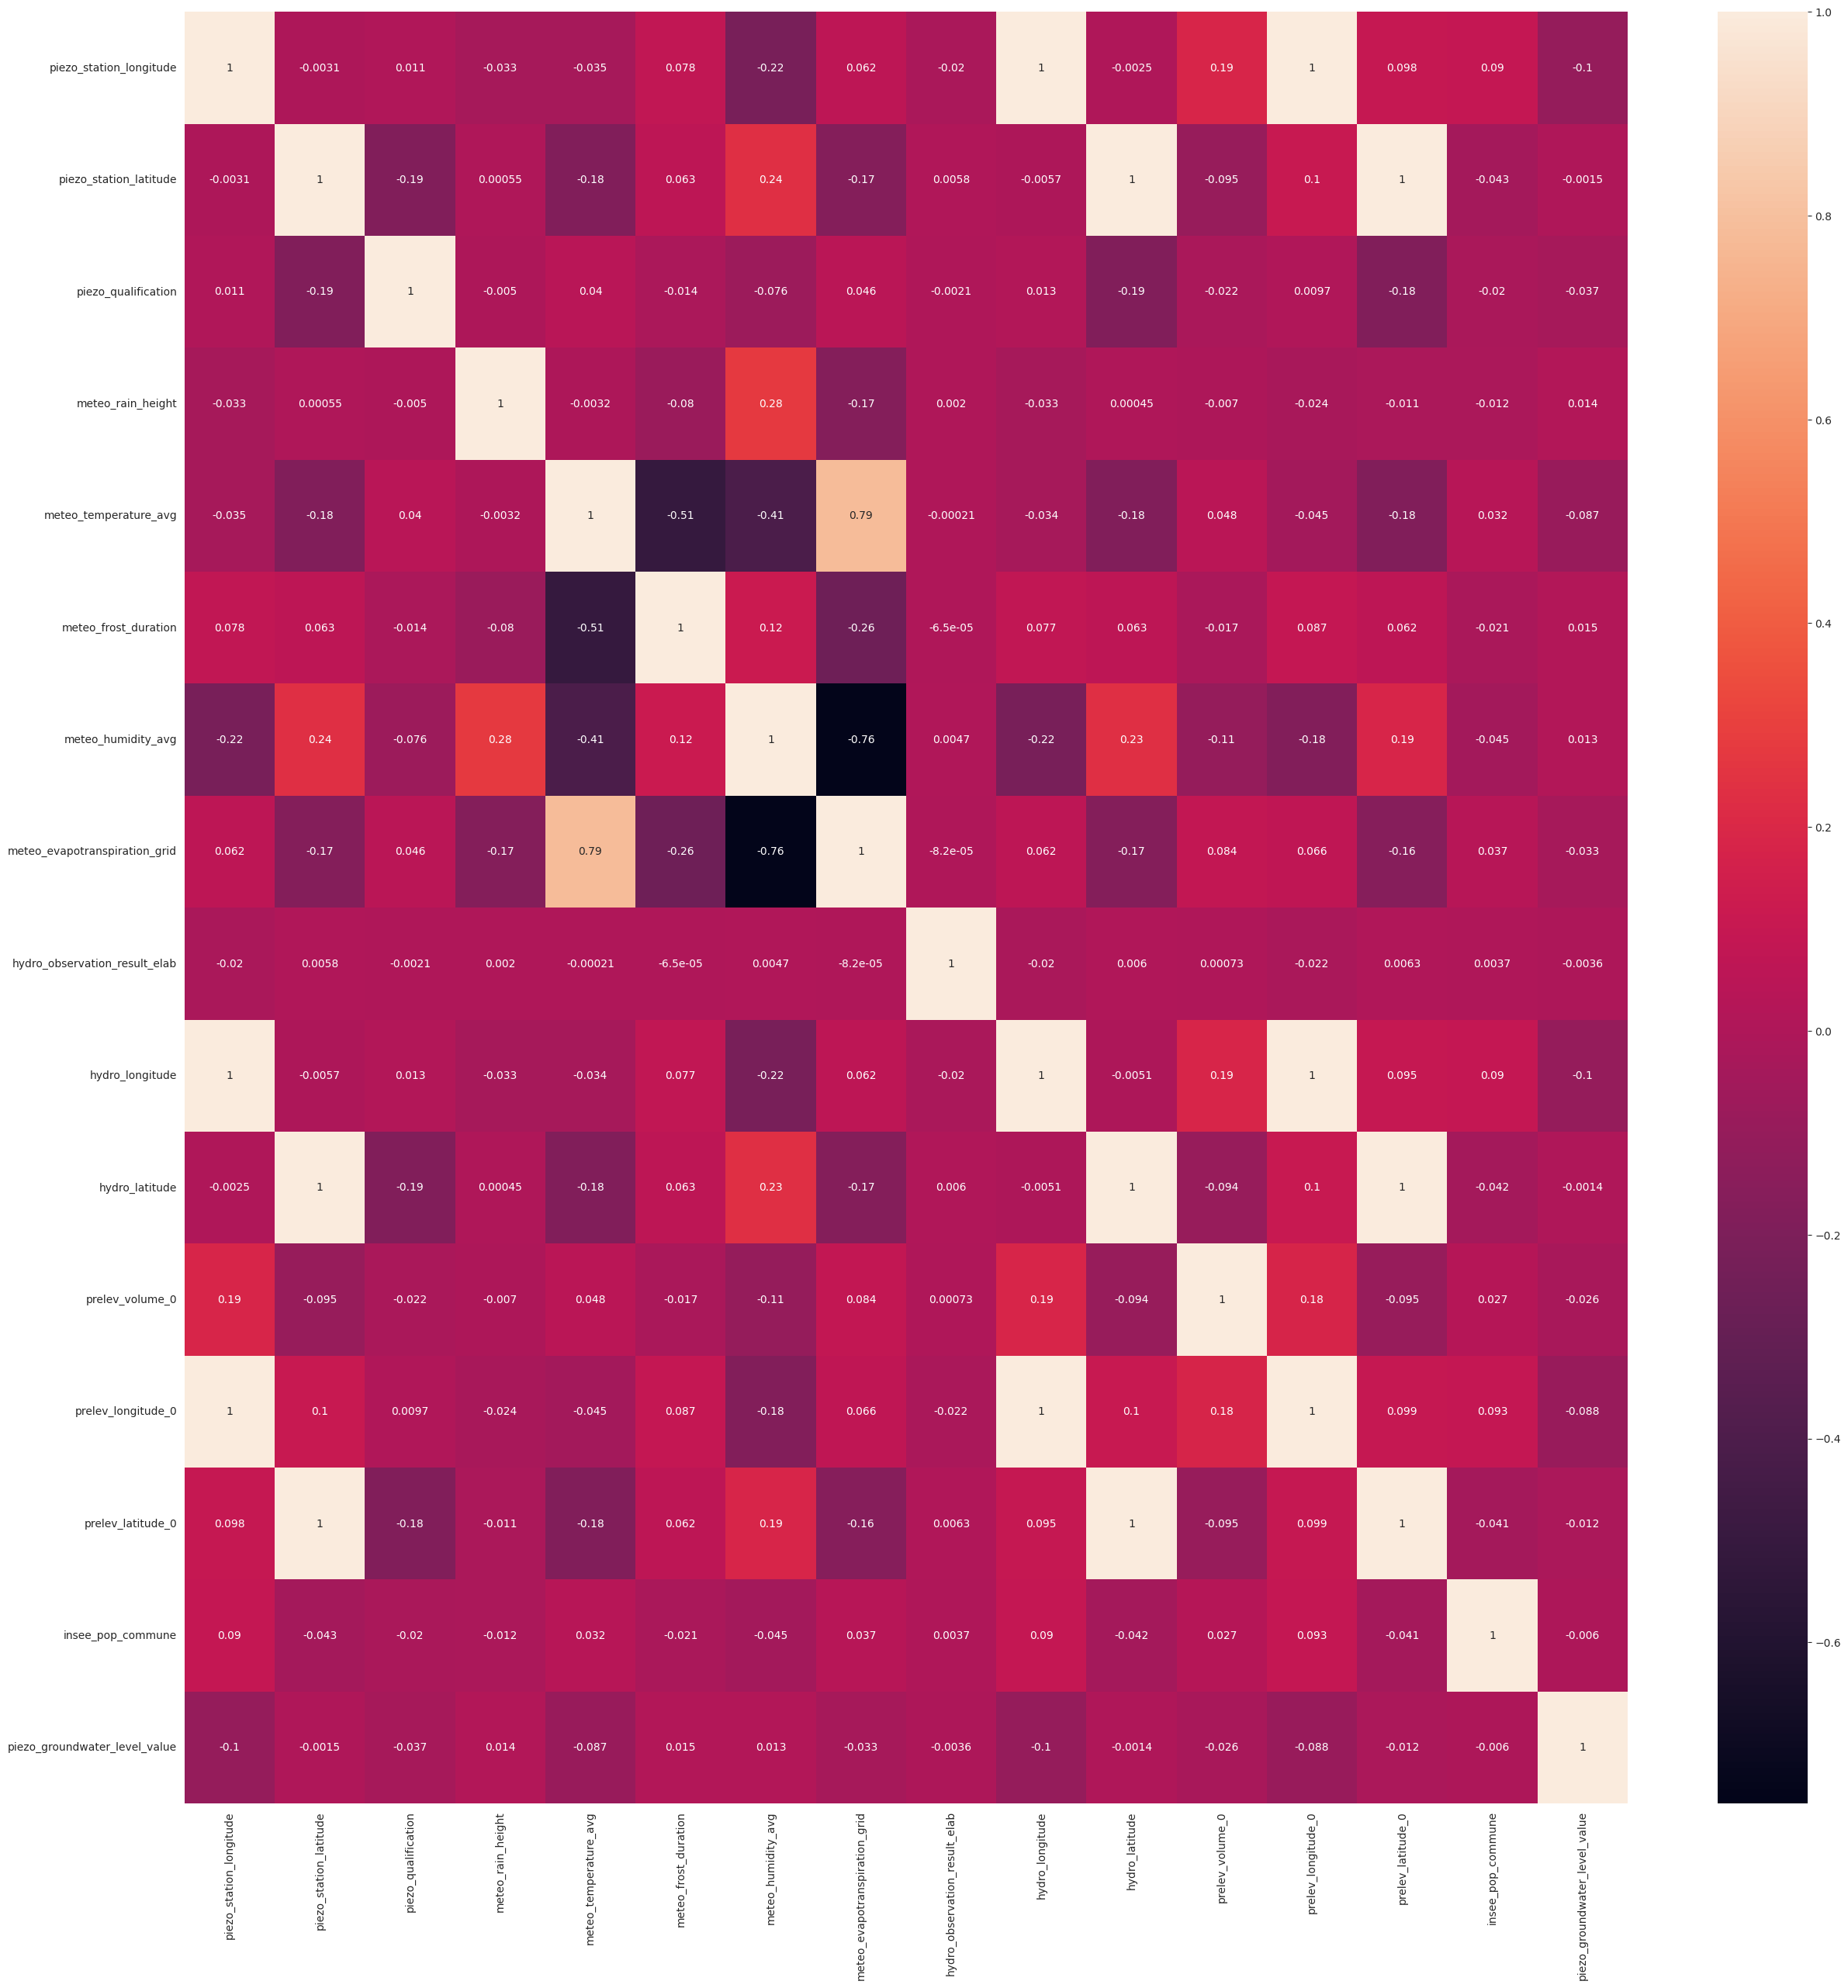

In [182]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(30, 30))
sns.heatmap(data=corr, annot=True)

## Withdrawals distribution

In [127]:
withdrawal_df = pd.read_csv(
  'X_train_Hi5.csv',
  usecols=[
    'prelev_volume_0', 'prelev_usage_label_0',
    'prelev_volume_1', 'prelev_usage_label_1',
    'prelev_volume_2', 'prelev_usage_label_2'
  ]
)

/tmp/ipykernel_27601/2836559862.py:1: DtypeWarning:

Columns (110,117,124) have mixed types. Specify dtype option on import or set low_memory=False.



In [128]:
df_usage = pd.concat([withdrawal_df['prelev_usage_label_0'], withdrawal_df['prelev_usage_label_1'], withdrawal_df['prelev_usage_label_2']], axis=0).reset_index(drop=True)
df_volume = pd.concat([withdrawal_df['prelev_volume_0'], withdrawal_df['prelev_volume_1'], withdrawal_df['prelev_volume_2']], axis=0).reset_index(drop=True)

# Combine into a single DataFrame
result_df = pd.DataFrame({"usage": df_usage, "volume": df_volume})

In [142]:
normalized = result_df.groupby('usage').sum()
normalized['volume'] = normalized['volume'] / normalized['volume'].sum()

In [143]:
normalized

,volume
usage,
CANAUX,0.002848
EAU POTABLE,0.002043
EAU TURBINEE (barrage),0.965499
ENERGIE,0.027921
"INDUSTRIE et ACTIVITES ECONOMIQUES (hors irrigation, hors énergie)",0.001357
IRRIGATION,0.000332


<Axes: >

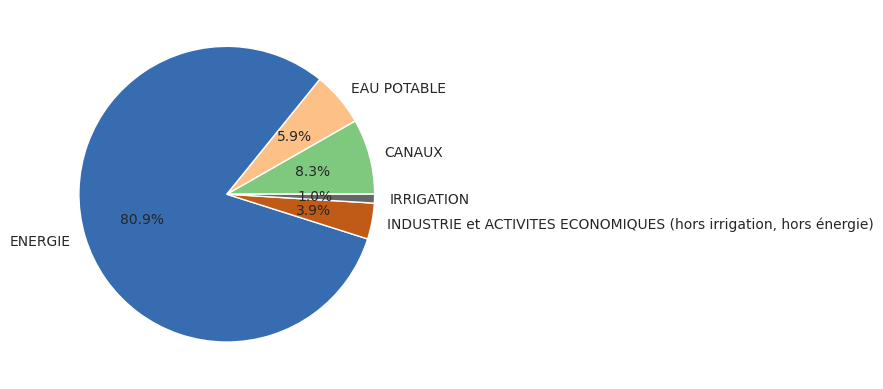

In [156]:
normalized.iloc[[0, 1, 3, 4, 5]].plot(kind='pie', y='volume', ylabel='', autopct='%1.1f%%', legend=False, colormap='Accent')

# Map plots

In [98]:
with open('departements.geojson', 'r') as file:
    geography = json.load(file)

## Average water levels on the dataset

In [94]:
avg_water_level = df.groupby('piezo_station_department_code')['piezo_groundwater_level_value'].mean().reset_index()
avg_water_level.rename(columns={'piezo_station_department_code': 'code'}, inplace=True)

In [95]:
prelev = df.groupby(['prelev_latitude_0', 'prelev_longitude_0', 'prelev_usage_label_0'])['prelev_volume_0'].mean().reset_index()
prelev['prelev_volume_std_0'] = np.log(prelev['prelev_volume_0'] ) / 3


In [96]:
hydro = df.groupby(['hydro_longitude', 'hydro_latitude'])['hydro_observation_result_elab'].mean().reset_index()
hydro = hydro.loc[hydro['hydro_observation_result_elab'] != 0]

In [124]:
import plotly.graph_objects as go

fig = go.Figure()

# fig.add_trace(go.Choroplethmapbox(
#   z=avg_water_level['piezo_groundwater_level_value'],
#   geojson=geography,
#   featureidkey='properties.code',
#   locations=avg_water_level['code'],
#   colorscale='rdylgn',
#   marker=dict(
#     opacity=0.7,
#   ),
#   colorbar_title='Average Water Level'
# ))

fig.add_trace(go.Scattermapbox(
    lat=hydro['hydro_latitude'],  # Replace with your actual latitude data
    lon=hydro['hydro_longitude'],  # Replace with your actual longitude data
    mode='markers',
    marker=dict(
        size=np.log(hydro['hydro_observation_result_elab']),  # Replace with your actual bubble size data column
        colorscale ='blues',  # You can set the color as desired
        opacity=0.9,
        color=hydro['hydro_observation_result_elab'],
      colorbar_title='Hydrologic measurement (m3/s)'
    ),
  text=[f"Water flow: {value:,.2f}m3/s" for value in hydro['hydro_observation_result_elab']],
  hovertemplate="<b>%{text}</b><extra></extra>",
  showlegend=False
))

fig.add_trace(go.Scattermapbox(
    lat=prelev['prelev_latitude_0'],  # Replace with your actual latitude data
    lon=prelev['prelev_longitude_0'],  # Replace with your actual longitude data
    mode='markers',
    marker=dict(
        size=np.log(prelev['prelev_volume_0']) / 2,  # Replace with your actual bubble size data column
        colorscale ='sunset',  # You can set the color as desired
        opacity=0.9,
        color=prelev['prelev_volume_0'],
        colorbar_x = -0.4,
      colorbar_title='Withdrawal volume (m3)'
    ),
  text=[f"{label}: {value:,.2f} m3" for label, value in zip(prelev['prelev_usage_label_0'], prelev['prelev_volume_0'])],
  hovertemplate="<b>%{text}</b><extra></extra>",
  showlegend=False
))

fig.update_geos(fitbounds='locations', projection_type='natural earth', visible=False)
fig.update_layout(
  mapbox_style="open-street-map",
  mapbox=dict(
      center=dict(
          lat=49,
          lon=0
      ),
      zoom=3.5,
  ),
  height=500,
  width=950
)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Average water levels on the dataset, by commune

In [ ]:
avg_water_level_commune = df.groupby('piezo_station_commune_code_insee')['piezo_groundwater_level_value'].mean().reset_index()
avg_water_level_commune.rename(columns={'piezo_station_commune_code_insee': 'code'}, inplace=True)

In [ ]:
with open('commune-frmetdrom.geojson', 'r') as file:
    commune_geography = json.load(file)

In [ ]:
fig = px.choropleth(avg_water_level_commune,
                    geojson=commune_geography,
                    featureidkey='properties.INSEE_COM',
                    locations='code',
                    color='piezo_groundwater_level_value',
                    projection='natural earth',
                    hover_name='code',
                    color_continuous_scale="rdylgn",
                    labels={'piezo_groundwater_level_value': 'Average Water Level'}
)
fig.update_geos(fitbounds='locations', visible=False)
fig.show()

## Average water level over time, by department

In [5]:
avg_water_dep = df.groupby(['piezo_station_department_code', 'piezo_measurement_date'])['piezo_groundwater_level_value'].mean().reset_index()

In [25]:
avg_water_dep_filtered = avg_water_dep.groupby('piezo_station_department_code').apply(lambda group: group.iloc[::15], include_groups=False).reset_index()

In [27]:
import plotly.graph_objects as go

initial_data = avg_water_dep_filtered[avg_water_dep_filtered['piezo_measurement_date'] == avg_water_dep_filtered['piezo_measurement_date'].min()]

fig = go.Figure(
  data=[
    go.Choroplethmapbox(
      z=initial_data['piezo_groundwater_level_value'],
      zmin=1,
      zmax=5,
      geojson=geography,
      featureidkey='properties.code',
      locations=initial_data['piezo_station_department_code'],
      colorscale='rdylgn',
      marker=dict(
        opacity=0.7,
      ),
      colorbar_title='Average Water Level'
    )],
  layout=go.Layout(
    title="Time-based Map with Slider",
    mapbox=dict(
        center=dict(lat=45, lon=0),
        zoom=3,
        style="open-street-map"
    ),
    updatemenus=[{
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 500, 'redraw': True}, 'fromcurrent': True}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }],
    sliders=[{
      'currentvalue': {
        'font': {'size': 20},
        'prefix': 'Date: ',
        'visible': True,
        'xanchor': 'center'
      },
      'steps': [
        {
          'args': [
              [str(date)],
              {'frame': {'duration': 300, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 300}}
          ],
          'label': str(date),
          'method': 'animate'
        }
        for date in avg_water_dep['piezo_measurement_date'].unique()
      ]
    }]
  ),
  frames=[
    go.Frame(
      data=[
        go.Choroplethmapbox(
          z=date_df['piezo_groundwater_level_value'],
          zmin=1,
          zmax=5,
          geojson=geography,
          featureidkey='properties.code',
          locations=date_df['piezo_station_department_code'],
          colorscale='rdylgn',
          marker=dict(
            opacity=0.7,
          ),
          colorbar_title='Average Water Level'
        )
      ],
      name=str(date)
    ) for date, date_df in avg_water_dep_filtered.groupby('piezo_measurement_date')
  ]
)
fig.write_html("file.html")

# Gathering data for meaningful measurements

## Averages

In [75]:
numerical_df = pd.concat([df.select_dtypes(include=[int, float]), df[['piezo_station_bss_id', 'piezo_measurement_date']]], axis=1)

In [76]:
avg_df = numerical_df.groupby(['piezo_station_bss_id', 'piezo_measurement_date']).mean().reset_index()

## Category encoding

For the averages, we use the most common categories for each group.

In [77]:
g = df.groupby(['piezo_station_bss_id', 'piezo_measurement_date'])['piezo_qualification'].agg(pd.Series.mode)

In [78]:
avg_df['piezo_qualification'] = g.reset_index()['piezo_qualification']

## Number of null columns

In [17]:
(avg_df.isna().sum() / len(avg_df)).sort_values(ascending=False)

meteo_radiation_IR               1.000000
meteo_wetting_duration           0.997444
meteo_cloudiness                 0.997384
meteo_cloudiness_height          0.997384
meteo_radiation_UV               0.997036
                                   ...   
distance_piezo_meteo             0.000000
hydro_observation_result_elab    0.000000
hydro_status_code                0.000000
hydro_method_code                0.000000
piezo_groundwater_level_value    0.000000
Length: 99, dtype: float64

Snow can have an influence, but must be evaluated (it's not ON the location itself)

# Timeseries plot

In [247]:
grouped = avg_df.groupby('piezo_station_bss_id')
first_5_groups = [grouped.get_group(group) for group in list(grouped.groups.keys())[:5]]

# Combine the first 5 groups into a single DataFrame
result = pd.concat(first_5_groups)

In [6]:
result.set_index('piezo_measurement_date', inplace=True)
result.index = pd.to_datetime(result.index)
result.interpolate(method='time', inplace=True)
result.reset_index()

<Axes: xlabel='piezo_measurement_date', ylabel='None'>

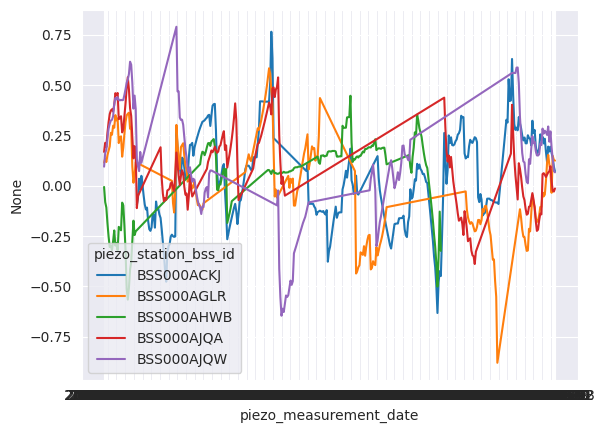

In [259]:
sns.lineplot(x=result['piezo_measurement_date'], y=result['meteo_rain_height'].rolling(window=30).corr(result['piezo_groundwater_level_value']), hue=result['piezo_station_bss_id'])

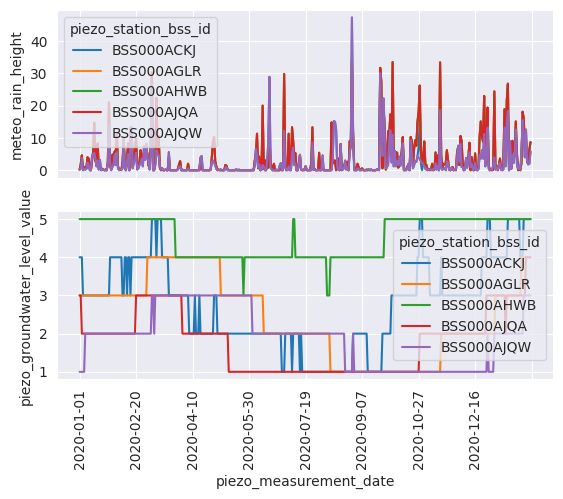

In [248]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

sns.lineplot(result, x='piezo_measurement_date', y='meteo_rain_height', hue='piezo_station_bss_id', ax=ax[0])
sns.lineplot(result, x='piezo_measurement_date', y='piezo_groundwater_level_value', hue='piezo_station_bss_id', ax=ax[1])
ax[1].xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=90)
plt.show()

# LSTM Model

In [152]:
selected_features = ['piezo_groundwater_level_value', 'meteo_rain_height', 'meteo_temperature_avg','prelev_volume_0']

grouped = avg_df.groupby('piezo_station_bss_id')

first_groups = [grouped.get_group(group) for group in list(grouped.groups.keys())[:100]]
X = pd.concat(first_groups)

X.set_index('piezo_measurement_date', inplace=True)
X.index = pd.to_datetime(X.index)
X.interpolate(method='time', inplace=True)
X = X.reset_index()
X.drop('piezo_measurement_date', axis=1, inplace=True)


# Combine the first 5 groups into a single DataFrame
X = X[selected_features]
Y = pd.get_dummies(X.pop('piezo_groundwater_level_value')).astype(int)

nb_features = len(X.columns)
nb_rows = len(X)

/tmp/ipykernel_98834/2288515041.py:10: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  X.interpolate(method='time', inplace=True)


In [261]:
X = (X - X.mean()) / X.std()

In [262]:
training_proportion = 0.5
validation_proportion = 0.25
test_split = 1 - training_proportion - validation_proportion

training_index = int(training_proportion * nb_rows)
validation_index = training_index + int(validation_proportion * nb_rows)

In [263]:
sampling_rate = 1 # Period between successive individual timesteps within sequences
sequence_length = 30 # Number of timesteps for each timeseries
delay = sampling_rate * (sequence_length + 7 - 1)  # Delay to start target values, in number of timesteps ; TODO: understand the -1
batch_size = 32

timeseries_kwargs = {
    'data': X[:-delay], # Don't include the last sequence
    'targets': Y[delay:],
    'sampling_rate': sampling_rate,
    'sequence_length': sequence_length,
    'batch_size': batch_size, # Shuffle the samples between them, not inside a sample of course
    'shuffle': True,
}

train_data = tf.keras.utils.timeseries_dataset_from_array(
    **timeseries_kwargs,
    end_index=training_index,
)

val_data = tf.keras.utils.timeseries_dataset_from_array(
    **timeseries_kwargs,
    start_index=training_index,  # Start and end index are also applied to targets
    end_index=validation_index,
)

test_data = tf.keras.utils.timeseries_dataset_from_array(
    **timeseries_kwargs,
    start_index=validation_index,
)

In [264]:
def lstm():
  input = keras.Input(shape=(sequence_length, X.shape[-1]))
  x = keras.layers.LSTM(16)(input)
  output = keras.layers.Dense(5, activation='softmax')(x)
  
  return keras.Model(inputs=input, outputs=output)

model = lstm()

In [265]:
learning_rate = 1e-4

model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.RMSprop(learning_rate),
              metrics=[keras.metrics.CategoricalAccuracy(name='accuracy')])

In [266]:
epochs = 15

date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs,
  callbacks=[
    keras.callbacks.TensorBoard(log_dir=f'logs/fit/LSTM-{date}', histogram_freq=1)
  ]
)

Epoch 1/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.2480 - loss: 1.5771 - val_accuracy: 0.1296 - val_loss: 1.6590
Epoch 2/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3118 - loss: 1.4968 - val_accuracy: 0.1301 - val_loss: 1.6949
Epoch 3/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3428 - loss: 1.4591 - val_accuracy: 0.1455 - val_loss: 1.6940
Epoch 4/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3574 - loss: 1.4444 - val_accuracy: 0.1478 - val_loss: 1.6952
Epoch 5/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3572 - loss: 1.4376 - val_accuracy: 0.1578 - val_loss: 1.6992
Epoch 6/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3646 - loss: 1.4327 - val_accuracy: 0.1701 - val_loss: 1.7061
Epoch 7/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.3669 - loss: 1.4282 - val_accuracy: 0.1775 - val_loss: 1.7113
Epoch 8/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3695 - loss: 1.4211 - val_accuracy: 0

In [267]:
model.evaluate(test_data)

280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2080 - loss: 1.7760


[1.7726227045059204, 0.2104322612285614]

# Data Pipeline

## Selecting and parsing features

In [187]:
selected_features = [
  'piezo_measurement_date', 'piezo_groundwater_level_value', 'piezo_station_longitude', 'piezo_station_latitude', 'piezo_qualification',
  'meteo_temperature_avg', 'meteo_humidity_avg', 'meteo_rain_height', 'meteo_evapotranspiration_grid', 'meteo_frost_duration',
  'hydro_observation_result_elab',
  'prelev_volume_0',
  'insee_pop_commune', 'insee_%_agri', "insee_%_const", "insee_med_living_level", "insee_%_ind"
]

work_df = df[selected_features].copy()

In [188]:
work_df['month'] = pd.factorize(work_df['piezo_measurement_date'].dt.strftime('%m'))[0]
work_df = work_df[(work_df['month'] >= 6) & (work_df['month'] <= 9)]

## NaN replacement

In [185]:
for c in [
    "insee_%_ind",
    "insee_%_const",
    "insee_%_agri",
    "insee_med_living_level",
    "insee_pop_commune"
]:
    df_insee = df[c]
    df_insee = df_insee.replace("N/A - division par 0", None)
    df_insee = df_insee.replace("N/A - résultat non disponible", None)
    df_insee = df_insee.astype(float)
    df[c] = df_insee

In [186]:
work_df.set_index('piezo_measurement_date', inplace=True)
work_df.interpolate(method='time', inplace=True)
work_df.fillna(work_df.median(), inplace=True)
work_df.reset_index(inplace=True)

/tmp/ipykernel_27601/4081366134.py:2: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



TypeError: Cannot convert [['11.8' '0.6' '0' ... '1.6' '0.2' '2.4']
 ['16.2' '11' '7.8' ... '4.8' '6.7' '8.9']
 ['25250' '24660' '24890' ... '31340' '28610' '25860']
 ['2.9' '44.5' '8.4' ... '4.8' '4.9' '4.1']] to numeric

## Date conversion

In [34]:
import math

work_df['day'] = pd.factorize(work_df['piezo_measurement_date'].dt.strftime('%d-%m'))[0]
work_df['day'] = (work_df['day'] - work_df['day'].min()) / (work_df['day'].max() - work_df['day'].min())
work_df['day'] = np.cos(2 * math.pi * work_df['day'])

In [35]:
work_df.drop(['piezo_measurement_date', 'month'], axis=1, inplace=True)

## Normalization

In [36]:
labels = work_df.pop('piezo_groundwater_level_value').astype(int) - 1

In [37]:
work_df = (work_df - work_df.mean())/work_df.std()
nb_features = len(work_df.columns)

## Train/test split

During training, we'll use a cross-validation method.

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(work_df, labels, test_size=0.2, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# Simple NN

In [84]:
def nn():
  input = keras.Input(shape=(nb_features,))
  x = keras.layers.Dense(16, activation='tanh')(input)
  x = keras.layers.Dropout(0.5)(x)
  output = keras.layers.Dense(5, activation='softmax')(x)
  
  return keras.Model(inputs=input, outputs=output)

model = nn()

In [95]:
learning_rate = 1e-4

model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.RMSprop(learning_rate),
              metrics=[keras.metrics.CategoricalAccuracy(name='accuracy')])

In [96]:
epochs = 40

date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
keras.config.disable_traceback_filtering()
model.fit(
  x=training_features.values,
  y=training_labels.values,
  validation_split=0.2,
  batch_size=128,
  epochs=epochs,
  callbacks=[
    keras.callbacks.TensorBoard(log_dir=f'logs/fit/NN-{date}', histogram_freq=1)
  ]
)

Epoch 1/40
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.2921 - loss: 1.5259 - val_accuracy: 0.3073 - val_loss: 1.5111
Epoch 2/40
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.2927 - loss: 1.5264 - val_accuracy: 0.3054 - val_loss: 1.5111
Epoch 3/40
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.2912 - loss: 1.5264 - val_accuracy: 0.3067 - val_loss: 1.5111
Epoch 4/40
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.2916 - loss: 1.5265 - val_accuracy: 0.3059 - val_loss: 1.5115
Epoch 5/40
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.2931 - loss: 1.5260 - val_accuracy: 0.3061 - val_loss: 1.5111
Epoch 6/40
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.2919 - loss: 1.5259 - val_accuracy: 0.3062 - val_loss: 1.5112
Epoch 7/40
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.2910 - loss: 1.5266 - val_accuracy: 0.3062 - val_loss: 1.5111
Epoch 8/40
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.2923 - loss: 1

KeyboardInterrupt: 

# XGBoost

## Grid search

In [39]:
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=5)

param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.3],
    # 'n_estimators': [50, 100, 200],
    # 'subsample': [0.7, 0.8, 0.9],
    # 'colsample_bytree': [0.7, 0.8, 0.9],
    # 'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    # 'reg_lambda': [0.1, 1, 10]  # L2 regularization
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

# Fit the model using grid search
grid_search.fit(training_features, training_labels)

# Best parameters found by grid search
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Best model
best_xgb_model = grid_search.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters found by GridSearchCV:
{'learning_rate': 0.3, 'max_depth': 9, 'reg_alpha': 1}


## Training with k-fold cross validation

## Final training, with early stopping

In [78]:
def f1_eval(y_pred, y_true):
    return f1_score(y_true, y_pred, average='weighted')

In [83]:
best_xgb = xgb.XGBClassifier(
  objective='multi:softmax',
  eval_metric=f1_eval,
  num_class=5,
  learning_rate=0.3,
  n_estimators=50,
  reg_alpha=1,
  max_depth=9
)
best_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

[0]	validation_0-mlogloss:1.50480	validation_0-f1_eval:0.46612	validation_1-mlogloss:1.50719	validation_1-f1_eval:0.46116
[1]	validation_0-mlogloss:1.42412	validation_0-f1_eval:0.50334	validation_1-mlogloss:1.42851	validation_1-f1_eval:0.49641
[2]	validation_0-mlogloss:1.36474	validation_0-f1_eval:0.52442	validation_1-mlogloss:1.37094	validation_1-f1_eval:0.51614
[3]	validation_0-mlogloss:1.31160	validation_0-f1_eval:0.55024	validation_1-mlogloss:1.31973	validation_1-f1_eval:0.53919
[4]	validation_0-mlogloss:1.27332	validation_0-f1_eval:0.56480	validation_1-mlogloss:1.28356	validation_1-f1_eval:0.55279
[5]	validation_0-mlogloss:1.23278	validation_0-f1_eval:0.58343	validation_1-mlogloss:1.24449	validation_1-f1_eval:0.57161
[6]	validation_0-mlogloss:1.20550	validation_0-f1_eval:0.59168	validation_1-mlogloss:1.21865	validation_1-f1_eval:0.57827
[7]	validation_0-mlogloss:1.17685	validation_0-f1_eval:0.60256	validation_1-mlogloss:1.19128	validation_1-f1_eval:0.58861
[8]	validation_0-mloglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=<function f1_eval at 0x7f23fdda31c0>,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [80]:
results = best_xgb.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

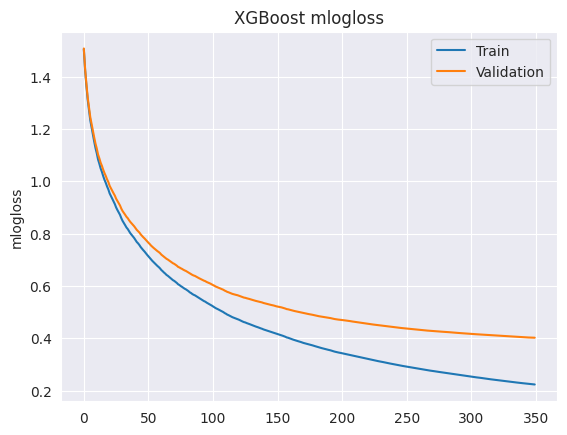

In [81]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
ax.legend()
plt.ylabel('mlogloss')
plt.title('XGBoost mlogloss')
plt.show()

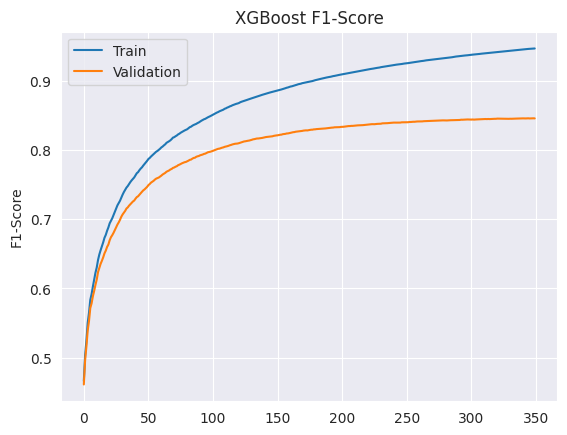

In [82]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['f1_eval'], label='Train')
ax.plot(x_axis, results['validation_1']['f1_eval'], label='Validation')
ax.legend()
plt.ylabel('F1-Score')
plt.title('XGBoost F1-Score')
plt.show()

In [91]:
best_xgb.save_model("xgb_model.json")

## Evaluation

In [90]:
from sklearn.metrics import f1_score

y_pred = best_xgb.predict(X_test)

score = f1_score(y_test, y_pred, average='weighted')
print("F1-Score: %.2f%%" % (score * 100.0))

F1-Score: 79.29%


# All dataset training

In [88]:
import time

timestamp = int(time.time())

work_df = work_df.sample(frac=1, random_state=timestamp)
labels = labels.sample(frac=1, random_state=timestamp)

In [89]:
best_xgb = xgb.XGBClassifier(
  objective='multi:softmax',
  eval_metric=f1_eval,
  num_class=5,
  learning_rate=0.3,
  n_estimators=60,
  reg_alpha=1,
  max_depth=9
)

best_xgb.fit(work_df, labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=<function f1_eval at 0x7f23fdda31c0>,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=60,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

## Feature importance

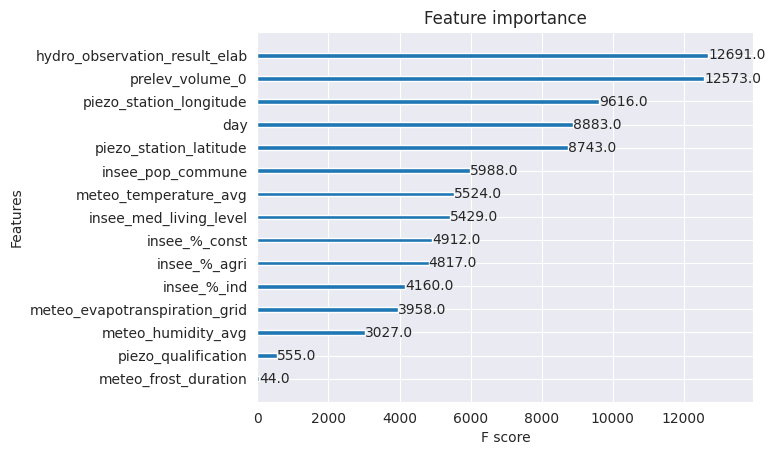

In [92]:
from xgboost import plot_importance
plot_importance(best_xgb)
plt.show()

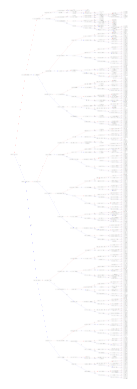

In [162]:
from xgboost import plot_tree
plot_tree(best_xgb, num_trees=0, rankdir='LR')
plt.show()

In [172]:
md = xgb.XGBClassifier(
  objective='multi:softmax',
  eval_metric=f1_eval,
  num_class=5,
  learning_rate=0.3,
  n_estimators=5,
  reg_alpha=1,
  max_depth=3
)

md.fit(work_df, labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=<function f1_eval at 0x7f23fdda31c0>,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=5,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

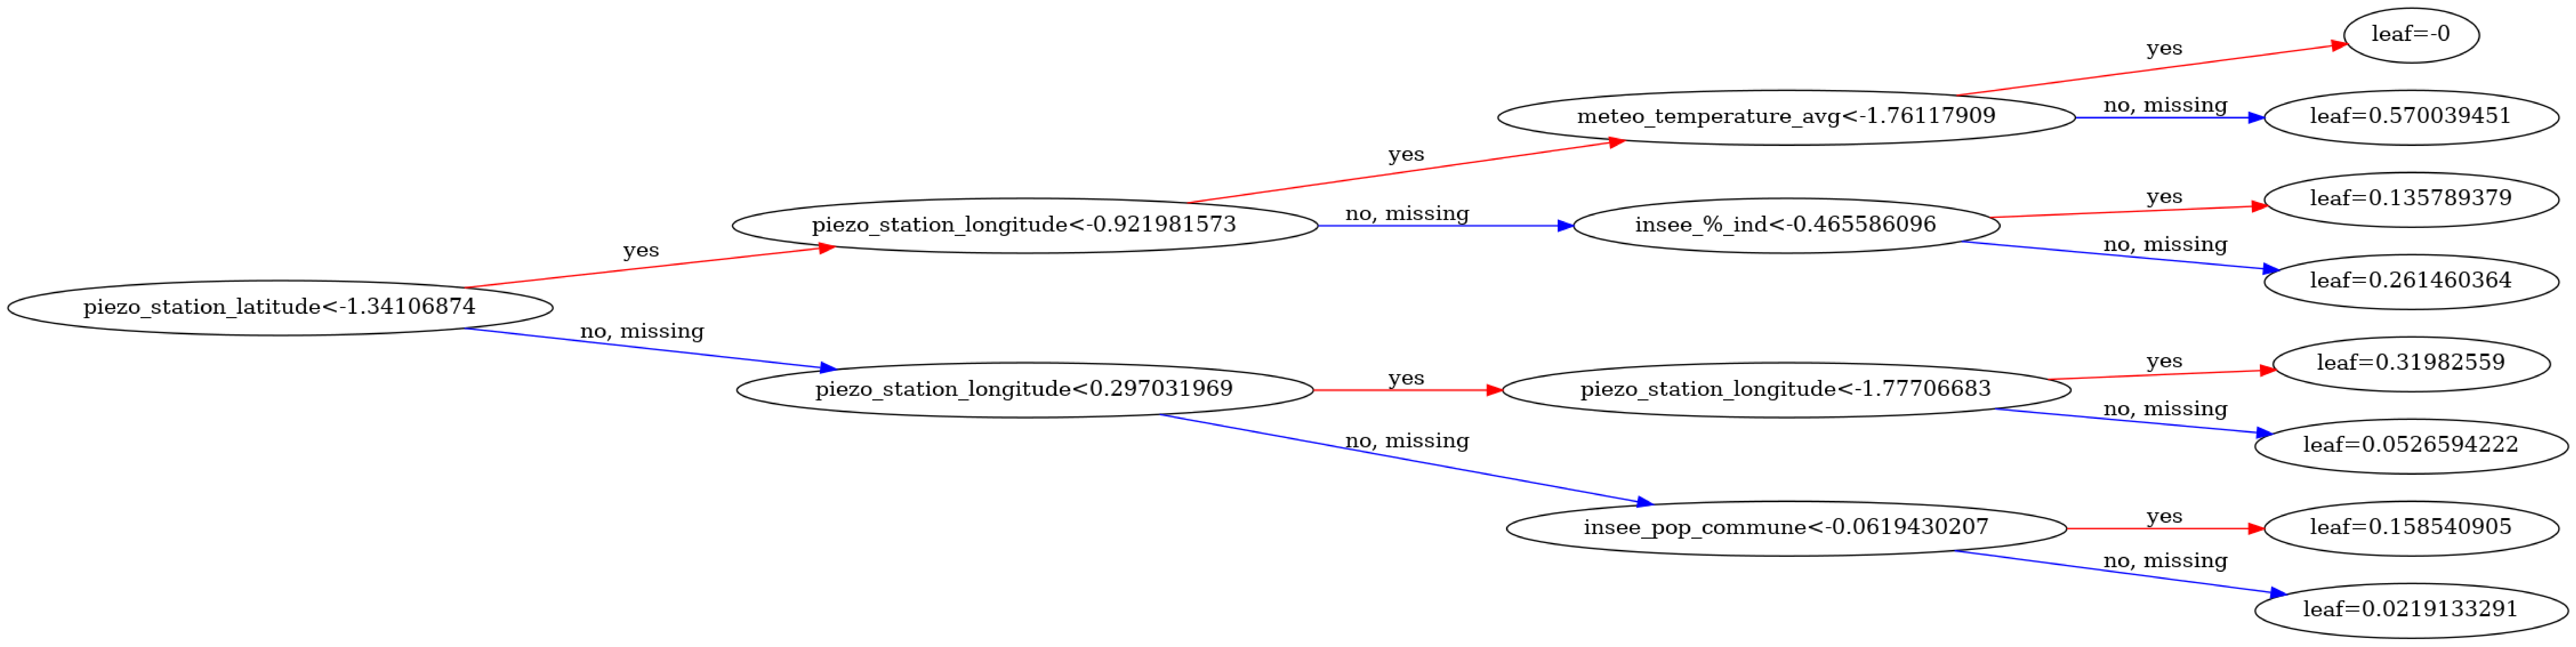

In [173]:
from xgboost import plot_tree
plot_tree(md, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.show()